In [147]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from LXRfunc import load_dataset,masked_normalization
from tensorflow.keras.preprocessing import sequence
from keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Embedding,Bidirectional,Masking,LSTM,BatchNormalization,Input
from keras.layers.merge import dot

import numpy as np
import keras
from keras.regularizers import l2,l1
from sklearn.utils import class_weight
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [148]:
steps = 50

In [149]:
X_train,y_train,X_test,y_test,num_classes = load_dataset('/mnt/lxr/SER/X_training.csv','/mnt/lxr/SER/y_training.csv','/mnt/lxr/SER/X_testing.csv','/mnt/lxr/SER/y_testing.csv',steps,0,136,True)

load succeed
There are  2 classes
shape of X_train:  (4917, 50, 136)
shape of X_test:  (707, 50, 136)
shape of y_train:  (4917, 2)
shape of y_test:  (707, 2)


In [150]:
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_ints),y_ints)
class_weights

/home/privacy/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

array([1.75607143, 0.69903327])

### Normalization

In [151]:
scaled_X_train,scaled_X_test = masked_normalization(X_train,X_test,scaler='ss')
X_train = scaled_X_train
X_test = scaled_X_test

### PCA

In [152]:
# reduced_dimension = 100
# scaled_X_train = np.reshape(scaled_X_train,(-1,scaled_X_train.shape[2]))
# scaled_X_test = np.reshape(scaled_X_test,(-1,scaled_X_test.shape[2]))
# pca = PCA(n_components = reduced_dimension)
# pca.fit(scaled_X_train)
# scaled_X_train = pca.transform(scaled_X_train)
# scaled_X_test = pca.transform(scaled_X_test)
# X_train  = np.reshape(scaled_X_train,(X_train.shape[0],X_train.shape[1],reduced_dimension))
# X_test  = np.reshape(scaled_X_test,(X_test.shape[0],X_test.shape[1],reduced_dimension))

In [153]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

In [154]:

def opt_select(optimizer,learning_rate):
    
    if optimizer == 'Adam':
        adamopt = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        return adamopt
    
    elif optimizer == 'SGD':
        
        SGDopt = tf.keras.optimizers.SGD(lr=learning_rate)
        return SGDopt
    
    elif optimizer == 'RMS':
        
        RMSopt = tf.keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-6)
        return RMSopt
    
    else:
        print('undefined optimizer')


In [426]:

def attention_model(X_train, y_train, X_val, y_val,X_test,num_classes,dropout=0.2, batch_size=68, learning_rate=0.0001,epochs=20,optimizer='Adam'):
    
    Dense_unit = 6
    LSTM_unit = 6
    
    dense_reg = 0.003
    attention_param = LSTM_unit*2
    attention_init_value = 1.0/attention_param
    
    
    u_train = np.full((X_train.shape[0], attention_param),
                      attention_init_value, dtype=np.float32)
    u_val = np.full((X_val.shape[0],attention_param),
                     attention_init_value, dtype=np.float32)
    u_test = np.full((X_test.shape[0],attention_param),
                     attention_init_value, dtype=np.float32)
    
    
    with keras.backend.name_scope('BLSTMLayer'):
        # Bi-directional Long Short-Term Memory for learning the temporal aggregation
        input_feature = Input(shape=(X_train.shape[1],X_train.shape[2]))
        x = Masking(mask_value=0)(input_feature)
        
#         x = BatchNormalization()(x)
        
        x = Dense(136,kernel_regularizer=l2(dense_reg),activation='relu')(x)
        x = Dropout(dropout)(x)
        x = Dense(25,kernel_regularizer=l2(dense_reg),activation='relu')(x)
        x = Dropout(dropout)(x)
        x = Dense(20,kernel_regularizer=l2(dense_reg),activation='relu')(x)
        x = Dropout(dropout)(x)
#         x = Dense(10,kernel_regularizer=l2(dense_reg),activation='relu')(x)
#         x = Dropout(dropout)(x)


        y = Bidirectional(LSTM(LSTM_unit,activity_regularizer=l2(0.0029),kernel_regularizer=l2(0.002),recurrent_regularizer=l2(0.002),return_sequences=True, dropout=dropout))(x)
        y = Bidirectional(LSTM(LSTM_unit,return_sequences=True, dropout=dropout))(y)
        y = Bidirectional(LSTM(LSTM_unit,activity_regularizer=l2(0.0029),kernel_regularizer=l2(0.002),recurrent_regularizer=l2(0.002),return_sequences=True, dropout=dropout))(y)


    with keras.backend.name_scope('AttentionLayer'):
        # Logistic regression for learning the attention parameters with a standalone feature as input
        input_attention = Input(shape=(LSTM_unit * 2,))
        u = Dense(LSTM_unit * 2, activation='softmax')(input_attention)

        # To compute the final weights for the frames which sum to unity
        alpha = dot([u, y], axes=-1)  # inner prod.
        alpha = Activation('softmax')(alpha)

    with keras.backend.name_scope('WeightedPooling'):
        # Weighted pooling to get the utterance-level representation
        z = dot([alpha, y], axes=1)

    # Get posterior probability for each emotional class
    output = Dense(num_classes, activation='softmax')(z)

    model = Model(inputs=[input_attention, input_feature], outputs=output)
#     model2 = Model(inputs=[input_attention, input_feature], outputs=model.get_layer('masking')).output
#     print(model2.predict(X_test))
    
    optimizer = opt_select(optimizer,learning_rate)
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    print(model.summary())
    callbacks = [EarlyStopping(monitor='val_loss', patience=200, verbose=0, mode='min'),
                 ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')]
    
    hist = model.fit([u_train, X_train], 
                     y_train, 
                     shuffle=False,
                     batch_size=batch_size, 
                     epochs=epochs, 
                     callbacks=callbacks,
                     class_weight = {0:1.75607143,1: 0.69903327},
                     validation_data=([u_val, X_val], y_val)
                    )
    
    model.load_weights(filepath = '.mdl_wts.hdf5')
    model.save('/mnt/lxr/SER/trained_models/Neutral.h5')
    
    y_pred = model.predict([u_test,X_test])
    
#    1.75607143, 0.69903327
# 2.76971831, 0.61014583 4.33597884, 0.56517241
#     kernel_regularizer=l2(0.002),recurrent_regularizer=l2(0.002),

    return hist,y_pred

In [427]:
batch_size= 256

#217
epochs = 300
lr = 0.0007

optimizer = 'RMS'
num_classes = y_train.shape[1]
dropout=0.35

In [428]:
tf.keras.backend.clear_session()
tf.random.set_seed(6)
history,y_pred = attention_model(X_train, y_train, X_val, y_val,X_test, num_classes,dropout = dropout,batch_size=batch_size, learning_rate=lr,epochs=epochs,optimizer=optimizer)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 136)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 50, 136)      0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 50, 136)      18632       masking[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50, 136)      0           dense[0][0]                      
_______________________________________________________________________________________

min loss  0.6393598318099976
highest acc 0.7154471278190613


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

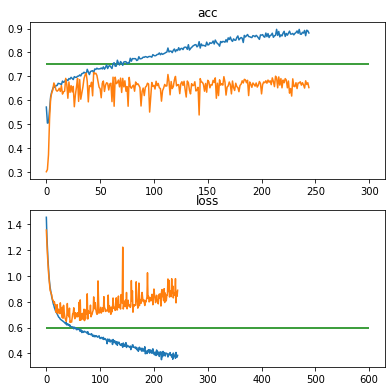

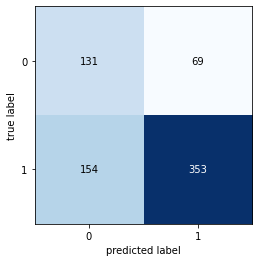

In [429]:
line_length = 0
fig = plt.figure(figsize=(14, 34))
 
ax = fig.add_subplot(10,2,1)
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.hlines(0.75,300,line_length,'g')

title = 'acc'
ax.title.set_text(title)

ax = fig.add_subplot(10,2,3)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.hlines(0.6,600,line_length,'g')

title = 'loss'
ax.title.set_text(title)

min_loss = min(history.history['val_loss'])
min_index = history.history['val_loss'].index(min_loss)
highest_acc = history.history['val_accuracy'][min_index]
print('min loss ',min_loss)
print('highest acc',highest_acc)

mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
plot_confusion_matrix(mat)

In [430]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.46      0.66      0.54       200
           1       0.84      0.70      0.76       507

    accuracy                           0.68       707
   macro avg       0.65      0.68      0.65       707
weighted avg       0.73      0.68      0.70       707



In [431]:
# attention_param = 3*2
# attention_init_value = 1.0/attention_param
# u_test = np.full((X_test.shape[0],attention_param),
#                      attention_init_value, dtype=np.float32)

In [164]:
# model2.evaluate([u_test,X_test],y_test)